# Regression

In [16]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/01'),Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/01.obj'),Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/02'),Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/02.obj'),Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/03'),Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/03.obj'),Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/04'),Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/04.obj'),Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/05'),Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/05.obj')...]

In [9]:
# Write a function that converts an image filename to its associated pose file
def img2pose(x): 
    return Path(f'{str(x)[:-7]}pose.txt')

img_files = get_image_files(path)
img2pose(img_files[0])

Path('C:/Users/joaqu/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt')

(480, 640)


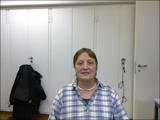

In [12]:
#Show the first image
im = PILImage.create(img_files[0])
print(im.shape)
im.to_thumb(160)

In [13]:
#Extract the head center point
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

get_ctr(img_files[0])

tensor([350.4915, 262.9643])

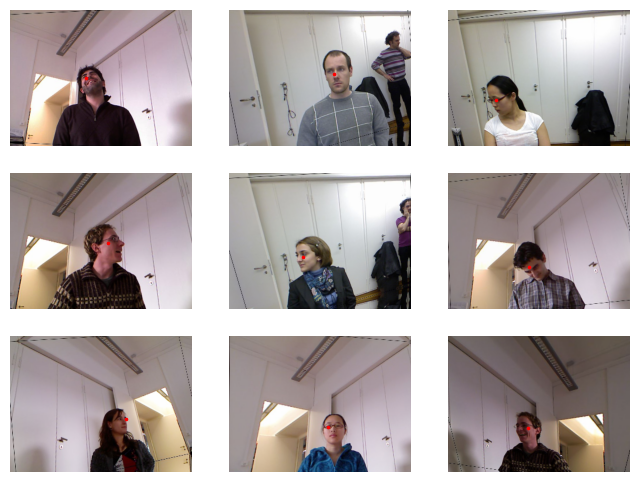

In [14]:
#Build datablock
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
    Normalize.from_stats(*imagenet_stats)]
    )

dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

## Training a model

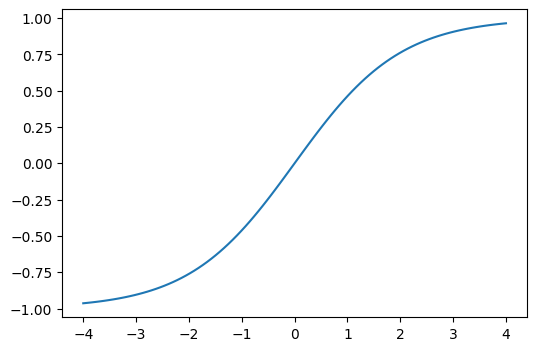

In [21]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

#modify sigmoid function
def sigmoid_range(x, lo, hi): 
    return torch.sigmoid(x) * (hi-lo) + lo

def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, steps = 100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)


In [22]:
#Loss funciton
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0010000000474974513)

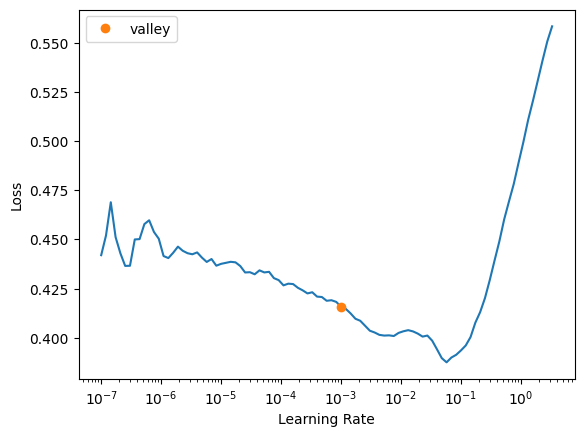

In [23]:
#learning rate finder
learn.lr_find()

In [24]:
# Train for few cycles
lr = 0.001
learn.fit_one_cycle(5, lr)


epoch,train_loss,valid_loss,time
0,0.263099,0.138595,04:41
1,0.036297,0.002283,02:11
2,0.011651,0.001199,02:08
3,0.008137,0.002328,02:08
4,0.006919,0.001277,02:08


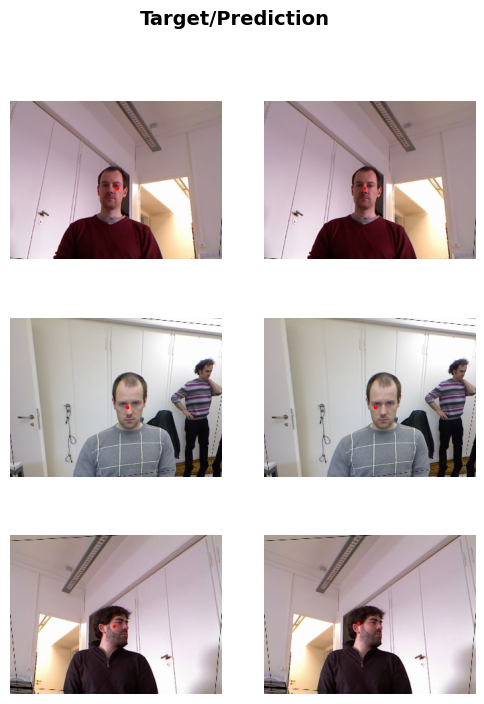

In [30]:
learn.show_results(ds_idx=0, max_n=3, figsize=(6,8))

### Conclusion

• nn.CrossEntropyLoss for single-label classification

• nn.BCEWithLogitsLoss for multi-label classification

• nn.MSELoss for regression